In [41]:
import pystac_client
import planetary_computer as pc

#import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely.geometry import Polygon
import os

In [6]:
def query_line(line, year):

    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["naip"], 
        intersects=line, 
        datetime=date_range)
    
    items =list(search.get_items()) 
    if len(items)==0:
        return None
    return items

In [3]:
fp = os.path.join(os.getcwd(),'aux_data','campuspoint2018polys/campuspoint2018polys.shp')
polys = gpd.read_file(fp)
polys.head()

'/home/jovyan/msai4earth-esa/iceplant_detection'

In [5]:
fp = os.path.join(os.getcwd(),'sb_county_coast','sb_county_coast.shp')
coast = gpd.read_file(fp)
coast

,id,geometry
0,0,"LINESTRING (-118.51632 34.07155, -118.80054 34..."


In [11]:
coast_scenes = query_line(coast.geometry[0],2018)

In [30]:
def make_bbox(item):
    c = item.properties['proj:bbox']
    return box(c[0],c[1],c[2],c[3])

In [21]:
df = pd.DataFrame(coast_scenes, columns = ['item'])


In [35]:
df['date']=df.item.apply(lambda item : item.properties['datetime'])
df['crs']=df.item.apply(lambda item : item.properties['proj:epsg'])
df['bbox']=df.item.apply(make_bbox)
df.head(4)

,item,date,crs,bbox
0,<Item id=ca_m_3512060_sw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722604 3875466, 722604 3882846, 7164..."
1,<Item id=ca_m_3512060_nw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722430 3882402, 722430 3889776, 7162..."
2,<Item id=ca_m_3512052_sw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722262 3889332, 722262 3896712, 7160..."
3,<Item id=ca_m_3512052_nw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722094 3896268, 722094 3903642, 7159..."


In [36]:
dates = df.date.unique()
dates

array(['2018-09-13T00:00:00Z', '2018-07-24T00:00:00Z',
       '2018-07-22T00:00:00Z', '2018-07-15T00:00:00Z'], dtype=object)

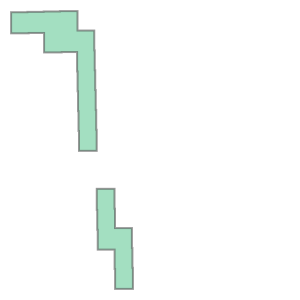

In [51]:
i=0
flight = df[df['date']==dates[i]]
area = Polygon()
for box in flight.bbox:
    area = area.union(box)
area

In [56]:
type(area)

shapely.geometry.multipolygon.MultiPolygon

In [59]:
d = {'geometry':[area],'date':dates[i]}
gdf = gpd.GeoDataFrame(d, crs='EPSG:'+str(flight.crs[0]))
flights = gdf.to_crs("EPSG:4326")

In [61]:
os.getcwd()

'/home/jovyan/msai4earth-esa/iceplant_detection'

In [62]:
flights.to_file(os.path.join(os.getcwd(),'training_set','aux_data'))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [63]:
os.path.join(os.getcwd(),'training_set','aux_data')

'/home/jovyan/msai4earth-esa/iceplant_detection/training_set/aux_data'